In [ ]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline


In [74]:
# Loading the dataset
data = pd.read_csv("Phone_Prices_Cleaned.csv")
data.head()

,brand,sd_card,resolution,display,sim_card,os,color,region,location,screen_size(inch),battery(mAh),storage(GB),ram(GB),selfie_camera(MP),price(¢)
0,Samsung,yes,1440 x 3040,AMOLED,Single,Android,White,Greater Accra,Circle,6.10,3400.0,128.0,8.0,10.0,2450.0
1,Samsung,yes,1440 x 3088,AMOLED,Dual,Android,Bronze,Greater Accra,Circle,6.90,4500.0,128.0,12.0,10.0,5000.0
2,Samsung,yes,1080 x 2340,Super AMOLED,Dual,Android,Black,Greater Accra,Accra Metropolitan,6.40,5000.0,256.0,8.0,32.0,3000.0
3,Tecno,no,1080 x 2400,AMOLED,Dual,Android,Black,Greater Accra,Accra Metropolitan,6.67,5000.0,256.0,8.0,32.0,1900.0
4,Samsung,no,Others,AMOLED,Dual,Android,Black,Greater Accra,Accra Metropolitan,6.80,5000.0,512.0,12.0,40.0,5750.0


In [75]:
# checking the size of the dataset
data.shape

(3338, 15)

In [76]:
# data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338 entries, 0 to 3337
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              3338 non-null   object 
 1   sd_card            3338 non-null   object 
 2   resolution         3338 non-null   object 
 3   display            3338 non-null   object 
 4   sim_card           3338 non-null   object 
 5   os                 3338 non-null   object 
 6   color              3338 non-null   object 
 7   region             3338 non-null   object 
 8   location           3338 non-null   object 
 9   screen_size(inch)  3338 non-null   float64
 10  battery(mAh)       3338 non-null   float64
 11  storage(GB)        3338 non-null   float64
 12  ram(GB)            3338 non-null   float64
 13  selfie_camera(MP)  3338 non-null   float64
 14  price(¢)           3338 non-null   float64
dtypes: float64(6), object(9)
memory usage: 391.3+ KB


In [77]:
# summary statistics
data.describe()

,screen_size(inch),battery(mAh),storage(GB),ram(GB),selfie_camera(MP),price(¢)
count,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000,3338.000000
mean,5.913939,3806.815159,146.893948,6.151887,12.943379,3512.192930
std,0.577587,881.210586,110.444956,2.457307,9.158026,3105.939546
min,1.800000,520.000000,4.000000,1.000000,0.000000,110.000000
25%,6.100000,3174.000000,64.000000,4.000000,8.000000,1650.000000
50%,6.100000,3700.000000,128.000000,6.000000,10.000000,2650.000000
75%,6.100000,4500.000000,256.000000,8.000000,13.000000,3950.000000
max,7.600000,7000.000000,1024.000000,16.000000,40.000000,26650.000000


In [78]:
# checking for missing values
data.isnull().sum()

brand                0
sd_card              0
resolution           0
display              0
sim_card             0
os                   0
color                0
region               0
location             0
screen_size(inch)    0
battery(mAh)         0
storage(GB)          0
ram(GB)              0
selfie_camera(MP)    0
price(¢)             0
dtype: int64

In [79]:
# checking and dropping duplicates
data=data.drop_duplicates()
data.duplicated().sum()

np.int64(0)

In [80]:
# checking numerical columns and their correlations
num_columns=data.select_dtypes(include=np.number)
num_columns
num_columns.corr()

,screen_size(inch),battery(mAh),storage(GB),ram(GB),selfie_camera(MP),price(¢)
screen_size(inch),1.000000,0.526355,0.361754,0.356697,0.300187,0.224846
battery(mAh),0.526355,1.000000,0.265741,0.375932,0.473552,0.200992
storage(GB),0.361754,0.265741,1.000000,0.479481,0.274570,0.533444
ram(GB),0.356697,0.375932,0.479481,1.000000,0.371803,0.467856
selfie_camera(MP),0.300187,0.473552,0.274570,0.371803,1.000000,0.111321
price(¢),0.224846,0.200992,0.533444,0.467856,0.111321,1.000000


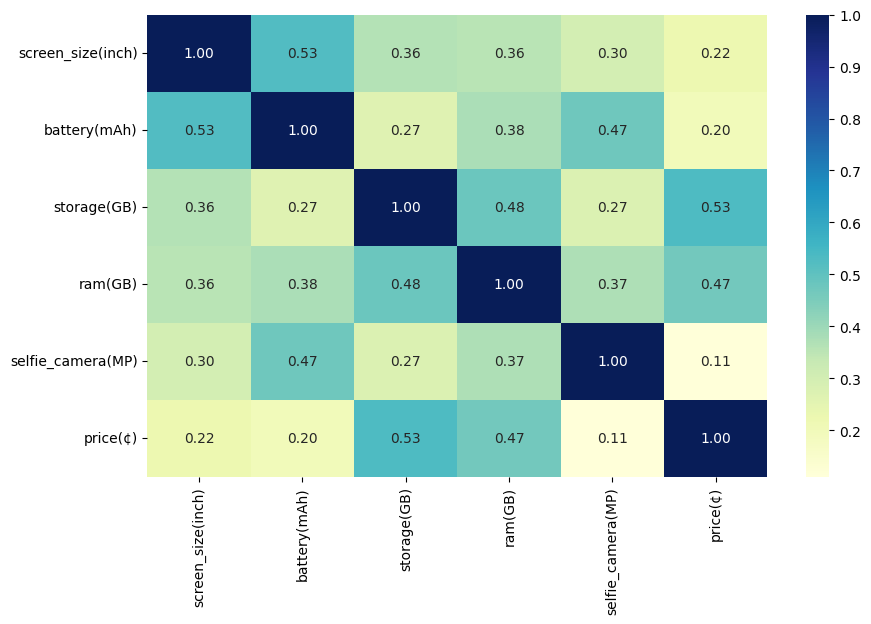

In [81]:
# heatmap for correlation
plt.figure(figsize=(10,6))  
sns.heatmap(num_columns.corr(),annot=True,fmt=".2f",cmap="YlGnBu")
plt.show()

In [82]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,OrdinalEncoder,LabelEncoder
# from Pipeline import Pipeline
X = data.drop("price(¢)", axis=1)
y = data["price(¢)"]

# ------------------ Split Data ------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------ Identify Features ------------------
num_features = X_train_raw.select_dtypes(exclude="object").columns
cat_features = X_train_raw.select_dtypes(include="object").columns

# ------------------ Preprocessor ------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ]
)

# ------------------ Models to Evaluate ------------------
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBRegressor": XGBRegressor(eval_metric='rmse'),
    "CatBoost": CatBoostRegressor(verbose=False, random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

# ------------------ Evaluation Function ------------------
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2 = r2_score(true, predicted)
    return mae, rmse, r2

# ------------------ Train & Evaluate ------------------
results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train_raw, y_train)

    y_pred = pipe.predict(X_test_raw)
    mae, rmse, r2 = evaluate_model(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })
    
    print(f" {name}")
    print(f"R2: {r2:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f}")
    print("-" * 40)


 Linear Regression
R2: 0.7143 | MAE: 1043.01 | RMSE: 1673.77
----------------------------------------
 Lasso
R2: 0.7163 | MAE: 1039.73 | RMSE: 1667.96
----------------------------------------
 Ridge
R2: 0.7153 | MAE: 1042.16 | RMSE: 1670.71
----------------------------------------
 KNN
R2: 0.8545 | MAE: 545.38 | RMSE: 1194.33
----------------------------------------
 Decision Tree
R2: 0.7496 | MAE: 523.31 | RMSE: 1566.92
----------------------------------------
 Random Forest
R2: 0.8865 | MAE: 415.31 | RMSE: 1054.76
----------------------------------------
 XGBRegressor
R2: 0.8803 | MAE: 444.61 | RMSE: 1083.32
----------------------------------------
 CatBoost
R2: 0.8923 | MAE: 455.01 | RMSE: 1027.60
----------------------------------------
 AdaBoost
R2: 0.5494 | MAE: 1765.43 | RMSE: 2101.94
----------------------------------------


In [83]:

# ------------------ Compare Results ------------------
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\n🏆 Model Comparison:\n", results_df)

# ------------------ Save Best Model ------------------
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Train pipeline again on full data
final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])
final_pipeline.fit(X, y)

# Save final model
with open("model.pkl", "wb") as f:
    pickle.dump(final_pipeline, f)

print(f"\n🎯 Best Model Saved: {best_model_name}")



🏆 Model Comparison:
                Model          MAE         RMSE        R2
7           CatBoost   455.008820  1027.602459  0.892306
5      Random Forest   415.311284  1054.762047  0.886538
6       XGBRegressor   444.605230  1083.318143  0.880311
3                KNN   545.375075  1194.325571  0.854526
4      Decision Tree   523.307003  1566.923884  0.749599
1              Lasso  1039.728170  1667.955872  0.716267
2              Ridge  1042.160211  1670.706874  0.715330
0  Linear Regression  1043.007722  1673.770943  0.714285
8           AdaBoost  1765.429490  2101.944220  0.549408

🎯 Best Model Saved: CatBoost
